### 1. Data Preprocessing

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

In [2]:
dir = Path('archive/train')
filepaths = list(dir.glob('**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath', dtype=str)
labels = pd.Series(labels, name='Label', dtype=str)

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

,Filepath,Label
0,archive\train\F\F1.png,F
1,archive\train\F\F10.png,F
2,archive\train\F\F100.png,F
3,archive\train\F\F101.png,F
4,archive\train\F\F102.png,F
...,...,...
99194,archive\train\V\V995.png,V
99195,archive\train\V\V996.png,V
99196,archive\train\V\V997.png,V
99197,archive\train\V\V998.png,V


In [3]:
dataframe['Label'].value_counts()

N    75709
M     8405
Q     6431
V     5789
S     2223
F      642
Name: Label, dtype: int64

### 2. Data Balancing

In [4]:
samples = []

for category in ['N', 'M', 'Q', 'V', 'S', 'F']:
    category_slice = dataframe.query('Label == @category')
    samples.append(category_slice.sample(640, random_state=1))
    
dataframe_train = pd.concat(samples, axis=0)
dataframe_train = dataframe_train.sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

N    640
Q    640
S    640
F    640
M    640
V    640
Name: Label, dtype: int64

In [5]:
dataframe_train

,Filepath,Label
0,archive\train\N\N80645.png,N
1,archive\train\Q\Q644.png,Q
2,archive\train\S\S2383.png,S
3,archive\train\S\S2269.png,S
4,archive\train\F\F138.png,F
...,...,...
3835,archive\train\S\S1594.png,S
3836,archive\train\M\M5641.png,M
3837,archive\train\M\M8804.png,M
3838,archive\train\N\N46498.png,N


### 3. Image Preprocessing and Data Augmentation

In [6]:
def gray_torgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.merge((image, image, image))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

In [7]:
'''
This code is to save the augmented ECG images into directory (Optional to run)
'''
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Directory defined to save the augmented images
save_dir = 'augmented_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Initialize the ImageDataGenerator with the desired augmentation parameters
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=gray_torgb,
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,            # Randomly rotate the images within the range of 20 degrees
    width_shift_range=0.2,        # Randomly shift the width of the image by 20% of the total width
    height_shift_range=0.2,       # Randomly shift the height of the image by 20% of the total height
    shear_range=0.2,              # Apply shear transformation with a shear intensity of 0.2
    zoom_range=0.2,               # Randomly zoom in or out of the images by 20%
    horizontal_flip=True,         # Randomly flip the images horizontally
    fill_mode='nearest'           # Fill any newly created pixels after rotation or shifting with the nearest value
)

# Load the original images
original_images = [load_img(file) for file in dataframe_train['Filepath']]

# Generate augmented images and save them
total_generated = 0
for i, img in enumerate(original_images):
    # Convert the image to an array
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    
    # Generate augmented images
    aug_generator = train_generator.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix=f'aug_{i}', save_format='png')
    num_augmented_images = 5  # Number of augmented images to generate for each original image
    for _ in range(num_augmented_images):
        augmented_image = next(aug_generator)
        total_generated += 1

print('Total number of images generated:', total_generated)
print('Augmented images saved in the directory:', save_dir)

Total number of images generated: 19200
Augmented images saved in the directory: augmented_images


In [8]:
# # Initialize the ImageDataGenerator with the desired augmentation parameters
# train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
#     preprocessing_function=gray_torgb,
#     rescale=1./255,
#     validation_split=0.2,
#     rotation_range=20,            # Randomly rotate the images within the range of 20 degrees
#     width_shift_range=0.2,        # Randomly shift the width of the image by 20% of the total width
#     height_shift_range=0.2,       # Randomly shift the height of the image by 20% of the total height
#     shear_range=0.2,              # Apply shear transformation with a shear intensity of 0.2
#     zoom_range=0.2,               # Randomly zoom in or out of the images by 20%
#     horizontal_flip=True,         # Randomly flip the images horizontally
#     fill_mode='nearest'           # Fill any newly created pixels after rotation or shifting with the nearest value
# )

### 4. Create Model

In [9]:
size = 224              
color_mode = 'rgb'      
batch_size = 32        

train_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,       
    x_col='Filepath',                
    y_col='Label',                   
    target_size=(size, size),        
    color_mode=color_mode,           
    class_mode='categorical',        
    batch_size=batch_size,           
    shuffle=True,                    
    seed=42,                         
    subset='training'                
)

val_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,       
    x_col='Filepath',               
    y_col='Label',                   
    target_size=(size, size),        
    color_mode=color_mode,           
    class_mode='categorical',        
    batch_size=batch_size,           
    shuffle=True,                    
    seed=42,                         
    subset='validation'              
)

Found 3072 validated image filenames belonging to 6 classes.
Found 768 validated image filenames belonging to 6 classes.


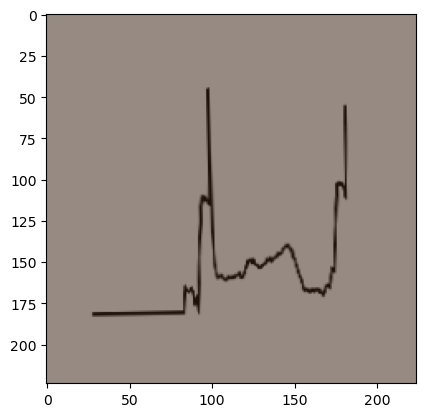

In [10]:
plt.imshow(train_images[0][0][3])

In [11]:
from tensorflow.keras.applications import ResNet50

pretrained_model = ResNet50(
    input_shape=(224,224,3),    
    include_top= False,         
    weights='imagenet', 
    pooling='avg'
)

pretrained_model.trainable=False

In [12]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

model = Sequential ([
    pretrained_model,
    Flatten(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 23858630 (91.01 MB)
Trainable params: 2709

### 5. Compile and Train the Model

In [13]:
model.compile(
    loss='categorical_crossentropy', optimizer='adam', 
    metrics=[
        'Accuracy', 
        'Precision', 
        'Recall',
         tf.keras.metrics.AUC(
             num_thresholds=200,
             curve='ROC',
             summation_method='interpolation',
             multi_label=False
         )
    ]
)

In [14]:
import tensorflow as tf

result = model.fit(
    train_images,
    steps_per_epoch=3072//32,
    validation_data=val_images,
    validation_steps=768//32,
    epochs=10
)

Epoch 1/10
96/96 [==============================] - 531s 6s/step - loss: 1.3998 - Accuracy: 0.3880 - precision: 0.6837 - recall: 0.1048 - auc: 0.7872 - val_loss: 1.0265 - val_Accuracy: 0.5052 - val_precision: 0.7500 - val_recall: 0.1875 - val_auc: 0.9044
Epoch 2/10
96/96 [==============================] - 624s 7s/step - loss: 0.9643 - Accuracy: 0.5625 - precision: 0.6893 - recall: 0.2975 - auc: 0.9049 - val_loss: 0.7657 - val_Accuracy: 0.6979 - val_precision: 0.7775 - val_recall: 0.4232 - val_auc: 0.9467
Epoch 3/10
96/96 [==============================] - 633s 7s/step - loss: 0.8316 - Accuracy: 0.6260 - precision: 0.6870 - recall: 0.4694 - auc: 0.9263 - val_loss: 0.7465 - val_Accuracy: 0.6667 - val_precision: 0.7342 - val_recall: 0.4674 - val_auc: 0.9418
Epoch 4/10
96/96 [==============================] - 373s 4s/step - loss: 0.7774 - Accuracy: 0.6458 - precision: 0.7074 - recall: 0.5163 - auc: 0.9344 - val_loss: 0.6951 - val_Accuracy: 0.7005 - val_precision: 0.7787 - val_recall: 0.591

In [15]:
model.save('ECG_Model_Augmentation.h5')

c:\Users\Xuanting\anaconda3\envs\pyspark\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
